In [392]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

import warnings
warnings.filterwarnings('ignore')

In [393]:
# 读取月度数据
data_monthly = pd.read_csv('original data/monthly/IDX_Idxtrdmth.csv')

# 修改表头
new_columns_monthly = {
    'Indexcd': 'Index_Code',          # 交易所指数代码
    'Month': 'Trade_Month',           # 交易月份
    'Opnidx': 'Open_Index',           # 开盘指数
    'Highidx': 'High_Index',          # 最高指数
    'Lowidx': 'Low_Index',            # 最低指数
    'Clsidx': 'Close_Index',          # 收盘指数
    'Idxrtn': 'Index_Return'          # 指数回报率
}
data_monthly = data_monthly.rename(columns=new_columns_monthly)

# 确保日期格式正确
data_monthly['Trade_Month'] = pd.to_datetime(data_monthly['Trade_Month'])

# 按日期排序
data_monthly = data_monthly.sort_values(by='Trade_Month')
data_monthly.head()

,Index_Code,Trade_Month,Open_Index,High_Index,Low_Index,Close_Index,Index_Return
0,1,1990-12-01,96.05,127.61,95.79,127.61,0.000000
1,1,1991-01-01,127.61,135.19,127.61,129.97,0.018494
2,1,1991-02-01,129.50,134.87,128.06,133.01,0.023390
3,1,1991-03-01,132.53,132.53,120.11,120.19,-0.096384
4,1,1991-04-01,120.69,122.20,113.89,113.94,-0.052001


In [394]:
# 计算过去12个月的累计收益率
data_monthly['Cumulative_Return'] = (1 + data_monthly['Index_Return']).rolling(window=12).apply(lambda x: x.prod() - 1)

# 计算慢速动量信号：如果过去12个月的累计收益率 >= 0，信号为1；否则为-1
data_monthly['Slow_Momentum'] = data_monthly['Cumulative_Return'].apply(lambda x: 1 if x >= 0 else -1)

# 计算快速动量信号（1个月）
data_monthly['Fast_Momentum'] = data_monthly['Index_Return'].rolling(window=1).apply(lambda x: 1 if x.iloc[-1] >= 0 else -1)

# 删除空缺数据（由于回望窗口导致的前1个月和前12个月数据缺失）
data_monthly = data_monthly.dropna()
data_monthly.head()

,Index_Code,Trade_Month,Open_Index,High_Index,Low_Index,Close_Index,Index_Return,Cumulative_Return,Slow_Momentum,Fast_Momentum
11,1,1991-11-01,220.71,259.85,218.60,259.60,0.187557,1.034324,1,1.0
12,1,1991-12-01,261.78,292.75,259.67,292.75,0.127696,1.294099,1,1.0
13,1,1992-01-01,293.74,313.24,292.76,313.24,0.069991,1.410093,1,1.0
14,1,1992-02-01,314.18,364.67,313.24,364.66,0.164155,1.741595,1,1.0
15,1,1992-03-01,365.15,382.06,364.66,381.24,0.045467,2.171975,1,1.0


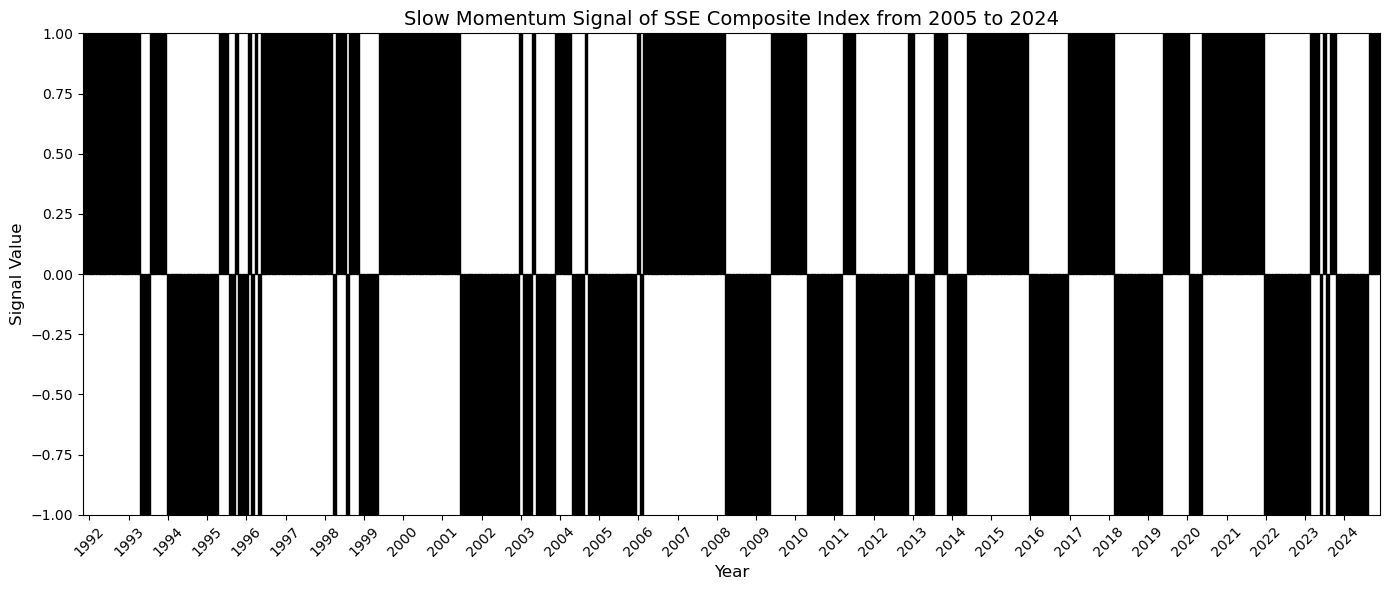

In [395]:
# 绘制慢速动量信号
plt.figure(figsize=(14, 6))
colors = np.where(data_monthly['Slow_Momentum'] == 1, 'black', 'black')
plt.bar(data_monthly['Trade_Month'], data_monthly['Slow_Momentum'], color=colors, edgecolor='black', width=25)
plt.title('Slow Momentum Signal of SSE Composite Index from 2005 to 2024', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Signal Value', fontsize=12)
plt.ylim(-1, 1)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 只显示年份
ax.xaxis.set_major_locator(mdates.YearLocator())  # 每年一个刻度
first_date = data_monthly['Trade_Month'].min()
last_date = data_monthly['Trade_Month'].max()
plt.xlim(first_date, last_date)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

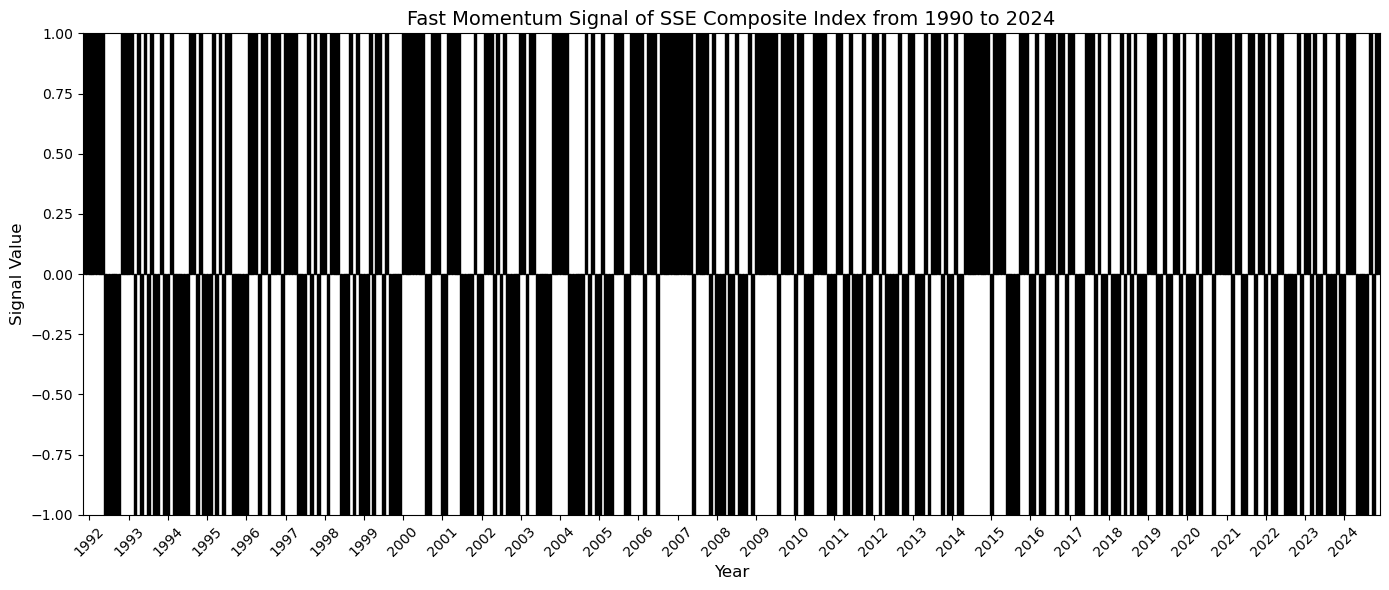

In [396]:
# 绘制快速动量信号
plt.figure(figsize=(14, 6))
colors = np.where(data_monthly['Fast_Momentum'] == 1, 'black', 'black')
plt.bar(data_monthly['Trade_Month'], data_monthly['Fast_Momentum'], color=colors, edgecolor='black', width=25)
plt.title('Fast Momentum Signal of SSE Composite Index from 1990 to 2024', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Signal Value', fontsize=12)
plt.ylim(-1, 1)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 只显示年份
ax.xaxis.set_major_locator(mdates.YearLocator())  # 每年一个刻度
first_date = data_monthly['Trade_Month'].min()
last_date = data_monthly['Trade_Month'].max()
plt.xlim(first_date, last_date)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [397]:
# 计算信号一致性
data_monthly['Signal_Agreement'] = data_monthly['Fast_Momentum'] == data_monthly['Slow_Momentum']

# 计算一致性的百分比
agreement_percentage = data_monthly['Signal_Agreement'].mean() * 100

print(f"快动量和慢动量信号方向一致的时间占比: {agreement_percentage:.2f}%")

快动量和慢动量信号方向一致的时间占比: 63.32%


In [398]:
# 定义数据路径
data_folder = "original data/daily"
file_names = ["IDX_Idxtrd_1.csv", "IDX_Idxtrd_2.csv", "IDX_Idxtrd_3.csv", "IDX_Idxtrd_4.csv", "IDX_Idxtrd_5.csv", "IDX_Idxtrd_6.csv", "IDX_Idxtrd_7.csv", "IDX_Idxtrd_8.csv", "IDX_Idxtrd_9.csv"]

In [399]:
# 读取所有数据文件并合并
data_list = []
for file_name in file_names:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    data_list.append(df)

# 合并所有数据
data_daily = pd.concat(data_list, ignore_index=True)
data_daily.head()

,Indexcd,Idxtrd01,Idxtrd02,Idxtrd03,Idxtrd04,Idxtrd05,Idxtrd08
0,1,1990-12-19,96.05,99.98,95.79,99.98,NaN
1,1,1990-12-20,104.30,104.39,99.98,104.39,4.4109
2,1,1990-12-21,109.07,109.13,103.73,109.13,4.5407
3,1,1990-12-24,113.57,114.55,109.13,114.55,4.9666
4,1,1990-12-25,120.09,120.25,114.55,120.25,4.9760


In [400]:
# 修改表头
new_columns_daily = {
    'Indexcd': 'Index_Code',          # 交易所指数代码
    'Idxtrd01': 'Trade_Date',         # 交易日期
    'Idxtrd02': 'Open_Index',         # 开盘指数
    'Idxtrd03': 'High_Index',         # 最高指数
    'Idxtrd04': 'Low_Index',          # 最低指数
    'Idxtrd05': 'Close_Index',        # 收盘指数
    'Idxtrd08': 'Index_Return'        # 指数回报率
}
data_daily = data_daily.rename(columns=new_columns_daily)

In [401]:
# 确保日期格式正确
data_daily['Trade_Date'] = pd.to_datetime(data_daily['Trade_Date'])

# 按日期排序
data_daily = data_daily.sort_values(by='Trade_Date')
data_daily.head()

,Index_Code,Trade_Date,Open_Index,High_Index,Low_Index,Close_Index,Index_Return
0,1,1990-12-19,96.05,99.98,95.79,99.98,NaN
1,1,1990-12-20,104.30,104.39,99.98,104.39,4.4109
2,1,1990-12-21,109.07,109.13,103.73,109.13,4.5407
3,1,1990-12-24,113.57,114.55,109.13,114.55,4.9666
4,1,1990-12-25,120.09,120.25,114.55,120.25,4.9760


In [402]:
# 计算每日回报率（使用Index_Return字段）
data_daily['Index_Return'] = data_daily['Index_Return']/100

# 计算滚动1个月（21个交易日）的波动率
data_daily['Volatility'] = data_daily['Index_Return'].rolling(window=21).std() * np.sqrt(21)

# 计算过去12个月的累计收益率
data_daily['Cumulative_Return_12month'] = (1 + data_daily['Index_Return']).rolling(window=252).apply(lambda x: x.prod() - 1)

# 计算慢速动量信号：如果过去12个月的累计收益率 >= 0，信号为1；否则为-1
data_daily['Slow_Momentum'] = data_daily['Cumulative_Return_12month'].apply(lambda x: 1 if x >= 0 else -1)

# 计算过去1个月的累计收益率
data_daily['Cumulative_Return_1month'] = (1 + data_daily['Index_Return']).rolling(window=21).apply(lambda x: x.prod() - 1)

# 计算慢速动量信号：如果过去1个月的累计收益率 >= 0，信号为1；否则为-1
data_daily['Fast_Momentum'] = data_daily['Cumulative_Return_1month'].apply(lambda x: 1 if x >= 0 else -1)

In [403]:
# 计算动量信号的回报
data_daily['Fast_Return'] = data_daily['Fast_Momentum'].shift(1) * data_daily['Index_Return']
data_daily['Slow_Return'] = data_daily['Slow_Momentum'].shift(1) * data_daily['Index_Return']

In [404]:
# 删除空缺数据（由于回望窗口导致的前1个月和前12个月数据缺失）
data_daily = data_daily.dropna()
data_daily.head()

,Index_Code,Trade_Date,Open_Index,High_Index,Low_Index,Close_Index,Index_Return,Volatility,Cumulative_Return_12month,Slow_Momentum,Cumulative_Return_1month,Fast_Momentum,Fast_Return,Slow_Return
252,1,1991-12-16,277.53,277.85,277.00,277.85,0.003069,0.013151,1.779065,1,0.166214,1,0.003069,-0.003069
253,1,1991-12-17,278.67,278.68,277.85,278.68,0.002987,0.013545,1.669613,1,0.158176,1,0.002987,0.002987
254,1,1991-12-18,279.32,279.51,278.68,279.51,0.002978,0.014137,1.561263,1,0.153856,1,0.002978,0.002978
255,1,1991-12-19,279.98,280.17,279.51,280.17,0.002361,0.014561,1.445836,1,0.145889,1,0.002361,0.002361
256,1,1991-12-20,282.83,282.83,280.63,282.83,0.009494,0.014843,1.352020,1,0.148268,1,0.009494,0.009494


In [405]:
# 计算累计收益（复利计算）
data_daily['Cumulative_Fast_Return'] = (1 + data_daily['Fast_Return']).cumprod()
data_daily['Cumulative_Slow_Return'] = (1 + data_daily['Slow_Return']).cumprod()
data_daily['Cumulative_Index_Return'] = (1 + data_daily['Index_Return']).cumprod()
data_daily.head()

,Index_Code,Trade_Date,Open_Index,High_Index,Low_Index,Close_Index,Index_Return,Volatility,Cumulative_Return_12month,Slow_Momentum,Cumulative_Return_1month,Fast_Momentum,Fast_Return,Slow_Return,Cumulative_Fast_Return,Cumulative_Slow_Return,Cumulative_Index_Return
252,1,1991-12-16,277.53,277.85,277.00,277.85,0.003069,0.013151,1.779065,1,0.166214,1,0.003069,-0.003069,1.003069,0.996931,1.003069
253,1,1991-12-17,278.67,278.68,277.85,278.68,0.002987,0.013545,1.669613,1,0.158176,1,0.002987,0.002987,1.006065,0.999909,1.006065
254,1,1991-12-18,279.32,279.51,278.68,279.51,0.002978,0.014137,1.561263,1,0.153856,1,0.002978,0.002978,1.009061,1.002887,1.009061
255,1,1991-12-19,279.98,280.17,279.51,280.17,0.002361,0.014561,1.445836,1,0.145889,1,0.002361,0.002361,1.011444,1.005254,1.011444
256,1,1991-12-20,282.83,282.83,280.63,282.83,0.009494,0.014843,1.352020,1,0.148268,1,0.009494,0.009494,1.021046,1.014798,1.021046


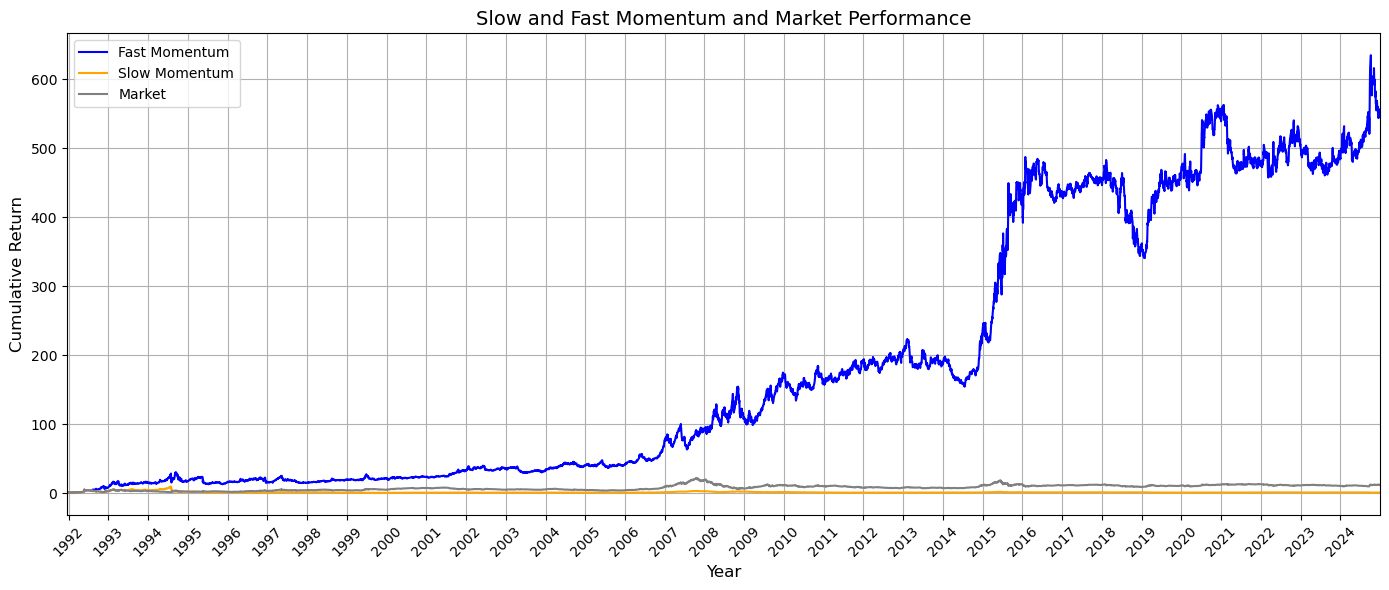

In [406]:
# 绘制累积回报曲线
plt.figure(figsize=(14, 6))
plt.plot(data_daily['Trade_Date'], data_daily['Cumulative_Fast_Return'], label='Fast Momentum', color='blue')
plt.plot(data_daily['Trade_Date'], data_daily['Cumulative_Slow_Return'], label='Slow Momentum', color='orange')
plt.plot(data_daily['Trade_Date'], data_daily['Cumulative_Index_Return'], label='Market', color='grey')
plt.title('Slow and Fast Momentum and Market Performance', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 只显示年份
ax.xaxis.set_major_locator(mdates.YearLocator())  # 每年一个刻度
plt.legend()
first_date = data_daily['Trade_Date'].min()
last_date = data_daily['Trade_Date'].max()
plt.xlim(first_date, last_date)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()

In [407]:
# 标注训练数据
data_daily["momentum_label"] = 0
data_daily["momentum_label"][data_daily["Fast_Return"] >= data_daily["Slow_Return"]] = 1

# 将波动率下移一个时间单位，作为下一时间单位的输入
data_daily["Volatility"].iloc[1:] = data_daily["Volatility"].iloc[:-1]

In [408]:
# 划分训练和测试集
# 训练集：1990-12-19 至 2015-12-31
# 测试集：2016-01-01 至 2024-8-31
# 确保 Trade_Date 是日期格式
data_daily['Trade_Date'] = pd.to_datetime(data_daily['Trade_Date'])

# 划分训练和测试集
train_data = data_daily[(data_daily['Trade_Date'] >= '1990-12-19') & (data_daily['Trade_Date'] <= '2015-12-31')]
test_data = data_daily[(data_daily['Trade_Date'] >= '2016-01-01') & (data_daily['Trade_Date'] <= '2024-8-31')]

In [409]:
train_data.head()

,Index_Code,Trade_Date,Open_Index,High_Index,Low_Index,Close_Index,Index_Return,Volatility,Cumulative_Return_12month,Slow_Momentum,Cumulative_Return_1month,Fast_Momentum,Fast_Return,Slow_Return,Cumulative_Fast_Return,Cumulative_Slow_Return,Cumulative_Index_Return,momentum_label
252,1,1991-12-16,277.53,277.85,277.00,277.85,0.003069,0.013151,1.779065,1,0.166214,1,0.003069,-0.003069,1.003069,0.996931,1.003069,1
253,1,1991-12-17,278.67,278.68,277.85,278.68,0.002987,0.013151,1.669613,1,0.158176,1,0.002987,0.002987,1.006065,0.999909,1.006065,1
254,1,1991-12-18,279.32,279.51,278.68,279.51,0.002978,0.013545,1.561263,1,0.153856,1,0.002978,0.002978,1.009061,1.002887,1.009061,1
255,1,1991-12-19,279.98,280.17,279.51,280.17,0.002361,0.014137,1.445836,1,0.145889,1,0.002361,0.002361,1.011444,1.005254,1.011444,1
256,1,1991-12-20,282.83,282.83,280.63,282.83,0.009494,0.014561,1.352020,1,0.148268,1,0.009494,0.009494,1.021046,1.014798,1.021046,1


In [410]:
test_data.head()

,Index_Code,Trade_Date,Open_Index,High_Index,Low_Index,Close_Index,Index_Return,Volatility,Cumulative_Return_12month,Slow_Momentum,Cumulative_Return_1month,Fast_Momentum,Fast_Return,Slow_Return,Cumulative_Fast_Return,Cumulative_Slow_Return,Cumulative_Index_Return,momentum_label
6125,1,2016-01-04,3536.589,3538.689,3295.741,3296.258,-0.068638,0.057066,0.053983,1,-0.080495,-1,-0.068638,-0.068638,400.137317,1.265076,11.899495,1
6126,1,2016-01-05,3196.651,3328.139,3189.605,3287.711,-0.002593,0.087697,0.084124,1,-0.067312,-1,0.002593,-0.002593,401.174873,1.261795,11.868640,1
6127,1,2016-01-06,3291.195,3362.974,3288.933,3361.840,0.022547,0.086650,0.130973,1,-0.049501,-1,-0.022547,0.022547,392.129584,1.290245,12.136242,0
6128,1,2016-01-07,3309.657,3309.657,3115.885,3125.002,-0.070449,0.090210,0.017080,1,-0.099440,-1,0.070449,-0.070449,419.754721,1.199348,11.281256,1
6129,1,2016-01-08,3194.625,3235.451,3056.878,3186.412,0.019651,0.112250,0.009128,1,-0.082370,-1,-0.019651,0.019651,411.506121,1.222917,11.502944,0


In [411]:
# 训练决策树模型
X_train = train_data["Volatility"].values.reshape(-1, 1)
y_train = train_data["momentum_label"]

clf = DecisionTreeClassifier(max_depth=3)  # 设置最大深度为 3
clf = clf.fit(X_train, y_train)

# 预测测试集
X_test = test_data["Volatility"].values.reshape(-1, 1)
y_predict = clf.predict(X_test)

In [412]:
# 动态选择策略
test_data["tree_momentum_flag"] = test_data["Fast_Momentum"]
test_data["tree_momentum_flag"] = np.where(
    y_predict == 1,  # 如果预测为 1，选择 Fast Momentum
    test_data["Fast_Momentum"],
    test_data["Slow_Momentum"]
)

In [413]:
test_data.head()

,Index_Code,Trade_Date,Open_Index,High_Index,Low_Index,Close_Index,Index_Return,Volatility,Cumulative_Return_12month,Slow_Momentum,Cumulative_Return_1month,Fast_Momentum,Fast_Return,Slow_Return,Cumulative_Fast_Return,Cumulative_Slow_Return,Cumulative_Index_Return,momentum_label,tree_momentum_flag
6125,1,2016-01-04,3536.589,3538.689,3295.741,3296.258,-0.068638,0.057066,0.053983,1,-0.080495,-1,-0.068638,-0.068638,400.137317,1.265076,11.899495,1,-1
6126,1,2016-01-05,3196.651,3328.139,3189.605,3287.711,-0.002593,0.087697,0.084124,1,-0.067312,-1,0.002593,-0.002593,401.174873,1.261795,11.868640,1,-1
6127,1,2016-01-06,3291.195,3362.974,3288.933,3361.840,0.022547,0.086650,0.130973,1,-0.049501,-1,-0.022547,0.022547,392.129584,1.290245,12.136242,0,-1
6128,1,2016-01-07,3309.657,3309.657,3115.885,3125.002,-0.070449,0.090210,0.017080,1,-0.099440,-1,0.070449,-0.070449,419.754721,1.199348,11.281256,1,-1
6129,1,2016-01-08,3194.625,3235.451,3056.878,3186.412,0.019651,0.112250,0.009128,1,-0.082370,-1,-0.019651,0.019651,411.506121,1.222917,11.502944,0,-1


In [414]:
# 根据 tree_momentum_flag 选择 Fast_Return 或 Slow_Return
test_data["tree_momentum_return"] = np.where(
    test_data["tree_momentum_flag"] == 1,  # 如果 tree_momentum_flag 为 1，选择 Fast_Return
    test_data["Fast_Return"],              # 否则选择 Slow_Return
    test_data["Slow_Return"]
)
test_data["Mix_return"] = 0.5 * test_data["Fast_Return"] + 0.5 * test_data["Slow_Return"]

In [415]:
# 计算累计收益
test_data["Cumulative_Tree_Return"] = (1 + test_data["tree_momentum_return"]).cumprod()
test_data["Cumulative_Mix_Return"] = (1 + test_data["Mix_return"]).cumprod()
test_data["Cumulative_Fast_Return"] = (1 + test_data["Fast_Return"]).cumprod()
test_data["Cumulative_Slow_Return"] = (1 + test_data["Slow_Return"]).cumprod()

In [416]:
test_data.head()

,Index_Code,Trade_Date,Open_Index,High_Index,Low_Index,Close_Index,Index_Return,Volatility,Cumulative_Return_12month,Slow_Momentum,...,Slow_Return,Cumulative_Fast_Return,Cumulative_Slow_Return,Cumulative_Index_Return,momentum_label,tree_momentum_flag,tree_momentum_return,Mix_return,Cumulative_Tree_Return,Cumulative_Mix_Return
6125,1,2016-01-04,3536.589,3538.689,3295.741,3296.258,-0.068638,0.057066,0.053983,1,...,-0.068638,0.931362,0.931362,11.899495,1,-1,-0.068638,-0.068638,0.931362,0.931362
6126,1,2016-01-05,3196.651,3328.139,3189.605,3287.711,-0.002593,0.087697,0.084124,1,...,-0.002593,0.933777,0.928947,11.868640,1,-1,-0.002593,0.000000,0.928947,0.931362
6127,1,2016-01-06,3291.195,3362.974,3288.933,3361.840,0.022547,0.086650,0.130973,1,...,0.022547,0.912723,0.949892,12.136242,0,-1,0.022547,0.000000,0.949892,0.931362
6128,1,2016-01-07,3309.657,3309.657,3115.885,3125.002,-0.070449,0.090210,0.017080,1,...,-0.070449,0.977024,0.882973,11.281256,1,-1,-0.070449,0.000000,0.882973,0.931362
6129,1,2016-01-08,3194.625,3235.451,3056.878,3186.412,0.019651,0.112250,0.009128,1,...,0.019651,0.957824,0.900324,11.502944,0,-1,0.019651,0.000000,0.900324,0.931362


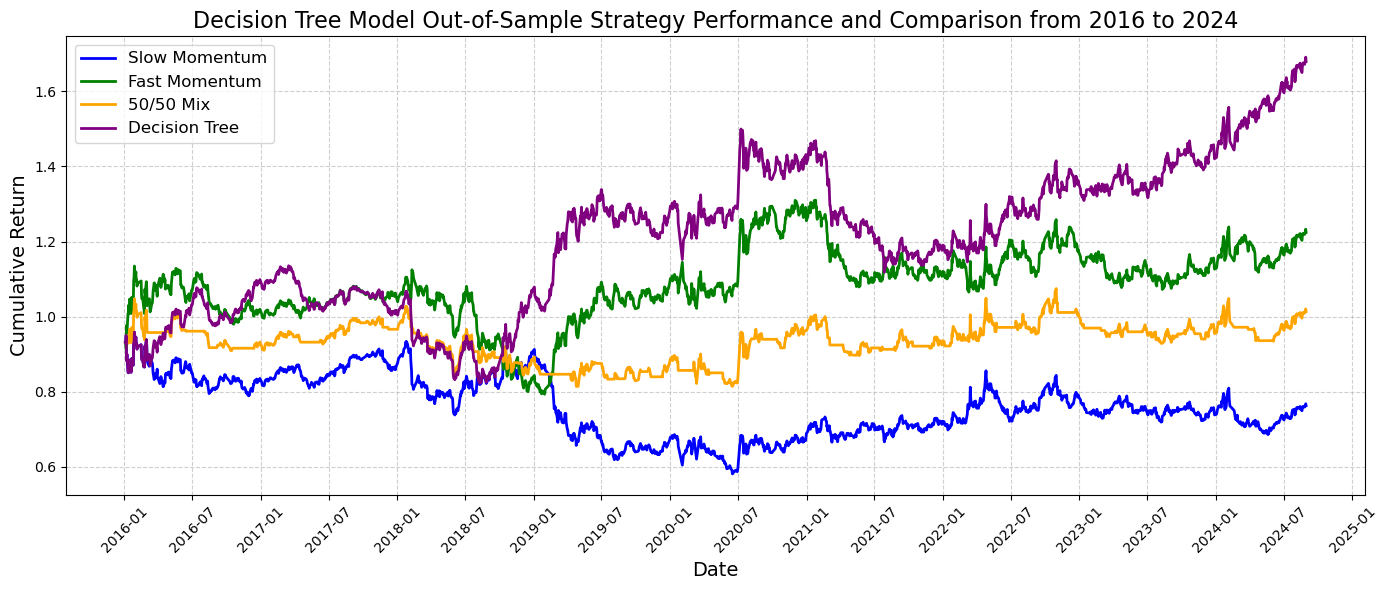

In [417]:
# 绘制累计收益图表
plt.figure(figsize=(14, 6))

# 绘制各策略的累计收益
plt.plot(test_data['Trade_Date'], test_data["Cumulative_Slow_Return"], label='Slow Momentum', color='blue', linewidth=2)
plt.plot(test_data['Trade_Date'], test_data["Cumulative_Fast_Return"], label='Fast Momentum', color='green', linewidth=2)
plt.plot(test_data['Trade_Date'], test_data["Cumulative_Mix_Return"], label='50/50 Mix', color='orange', linewidth=2)
plt.plot(test_data['Trade_Date'], test_data["Cumulative_Tree_Return"], label='Decision Tree', color='purple', linewidth=2)

# 添加标题和标签
plt.title('Decision Tree Model Out-of-Sample Strategy Performance and Comparison from 2016 to 2024', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.6)

# 添加图例
plt.legend(loc='upper left', fontsize=12)

# 设置 x 轴日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # 每 6 个月显示一个刻度

# 旋转 x 轴标签
plt.xticks(rotation=45)

# 显示图表
plt.tight_layout()
plt.show()

In [418]:
from scipy import stats

# 筛选出 Fast_Return 大于 Slow_Return 的行
filtered_data = data_daily[data_daily['Fast_Return'] > data_daily['Slow_Return']]

# 计算波动率的99%置信区间
volatility_values = filtered_data['Volatility'].dropna()  # 确保没有缺失值
confidence_level = 0.99
mean_volatility = np.mean(volatility_values)
std_volatility = np.std(volatility_values, ddof=1)  # 使用样本标准差
margin_of_error = stats.t.ppf((1 + confidence_level) / 2, len(volatility_values) - 1) * (std_volatility / np.sqrt(len(volatility_values)))

lower_bound = mean_volatility - margin_of_error
upper_bound = mean_volatility + margin_of_error

print(f"波动率的99%置信区间为: ({lower_bound:.4f}, {upper_bound:.4f})")
print(f"波动率的均值: {mean_volatility:.4f}")
print(f"波动率的标准差: {std_volatility:.4f}")

threshold = upper_bound  # 95%置信区间的上限
print(f"波动率在99%置信区间内大于: {threshold:.4f}")

波动率的99%置信区间为: (0.0768, 0.0854)
波动率的均值: 0.0811
波动率的标准差: 0.0649
波动率在99%置信区间内大于: 0.0854


In [419]:
# 确保 Mix_return 列存在
if 'Mix_return' not in data_daily.columns:
	data_daily['Mix_return'] = 0.5 * data_daily['Fast_Return'] + 0.5 * data_daily['Slow_Return']

# 筛选出 Mix_return 为零的行
mix_zero_count = len(data_daily[data_daily['Mix_return'] == 0])

# 计算 Mix_return 为零的比率
total_rows = len(data_daily)
mix_zero_ratio = mix_zero_count / total_rows
print(f"Mix_return 为零的比率: {mix_zero_ratio:.4f} (即 {mix_zero_ratio * 100:.2f}%)")

Mix_return 为零的比率: 0.3646 (即 36.46%)


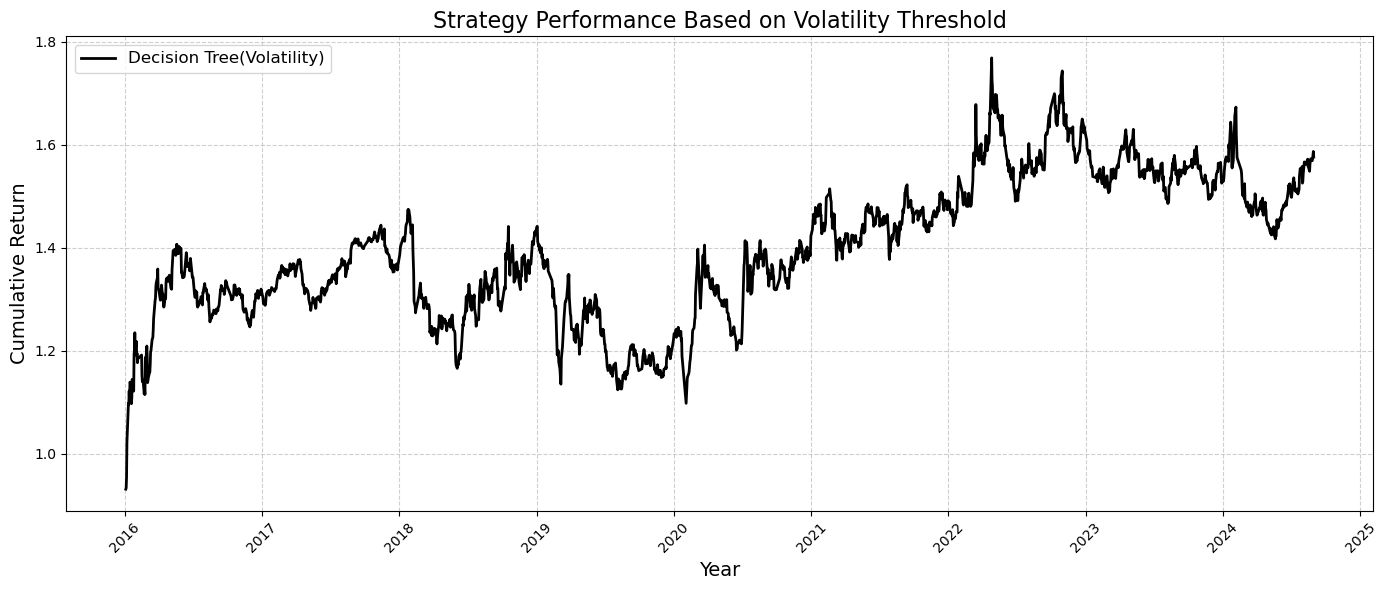

In [420]:
# 定义波动率阈值
volatility_threshold = 0.085  # 8.5%

# 根据波动率阈值和回报比较，设置决策规则
test_data['Strategy'] = np.where(
    (test_data['Volatility'] > volatility_threshold) & (test_data['Fast_Return'] > test_data['Slow_Return']),
    1,  # 快动量策略
    0   # 慢动量策略
)

# 计算样本外策略回报
test_data['Strategy_Return'] = np.where(
    test_data['Strategy'] == 1,
    test_data['Fast_Return'],  # 快动量策略回报
    test_data['Slow_Return']   # 慢动量策略回报
)

# 计算累积回报
test_data['Cumulative_Strategy_Return'] = (1 + test_data['Strategy_Return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(test_data['Trade_Date'], test_data['Cumulative_Strategy_Return'], label='Decision Tree(Volatility)', color='black', linewidth=2)

# 添加标题和标签
plt.title('Strategy Performance Based on Volatility Threshold', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)

# 设置 x 轴日期格式
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 只显示年份
ax.xaxis.set_major_locator(mdates.YearLocator())  # 每年一个刻度

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.6)

# 添加图例
plt.legend(loc='upper left', fontsize=12)

# 旋转 x 轴标签
plt.xticks(rotation=45)

# 显示图表
plt.tight_layout()
plt.show()

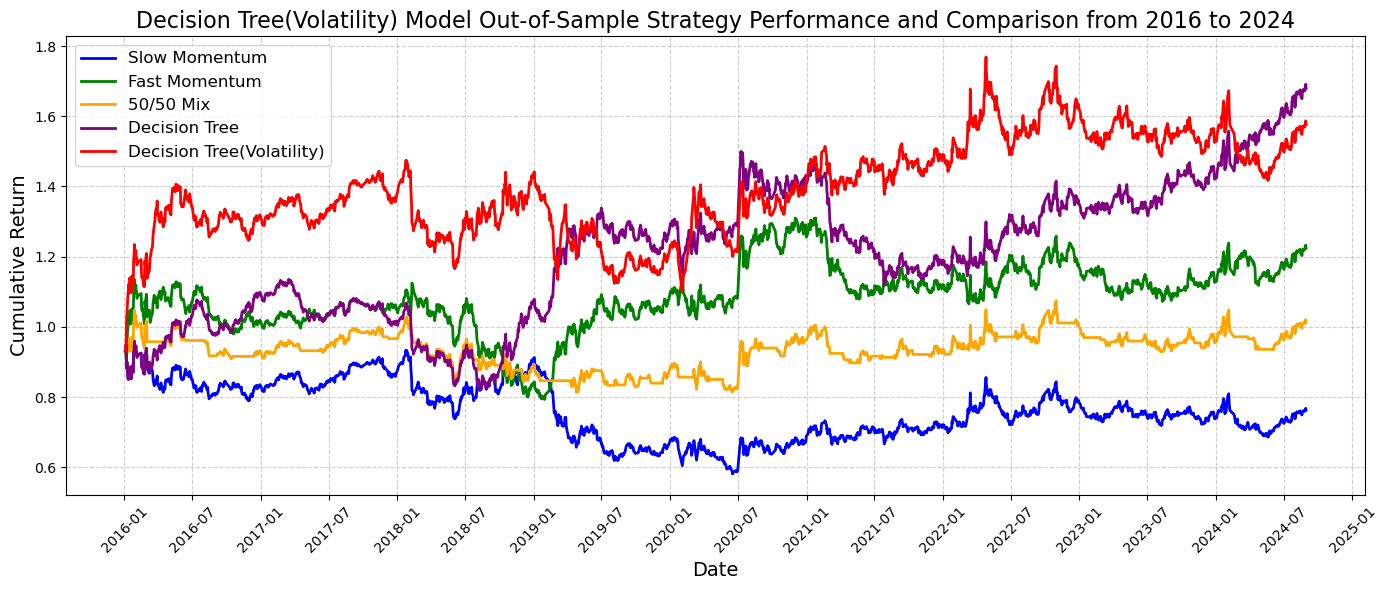

In [421]:
# 绘制累计收益图表
plt.figure(figsize=(14, 6))

# 绘制各策略的累计收益
plt.plot(test_data['Trade_Date'], test_data["Cumulative_Slow_Return"], label='Slow Momentum', color='blue', linewidth=2)
plt.plot(test_data['Trade_Date'], test_data["Cumulative_Fast_Return"], label='Fast Momentum', color='green', linewidth=2)
plt.plot(test_data['Trade_Date'], test_data["Cumulative_Mix_Return"], label='50/50 Mix', color='orange', linewidth=2)
plt.plot(test_data['Trade_Date'], test_data["Cumulative_Tree_Return"], label='Decision Tree', color='purple', linewidth=2)
plt.plot(test_data['Trade_Date'], test_data['Cumulative_Strategy_Return'], label='Decision Tree(Volatility)', color='red', linewidth=2)

# 添加标题和标签
plt.title('Decision Tree(Volatility) Model Out-of-Sample Strategy Performance and Comparison from 2016 to 2024', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.6)

# 添加图例
plt.legend(loc='upper left', fontsize=12)

# 设置 x 轴日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # 每 6 个月显示一个刻度

# 旋转 x 轴标签
plt.xticks(rotation=45)

# 显示图表
plt.tight_layout()
plt.show()

In [422]:
def calculate_metrics(returns):
    """
    计算年化收益率、年化波动率、夏普比率、最大回撤和命中率
    :param returns: 每日收益率序列（Pandas Series）
    :return: 年化收益率、年化波动率、夏普比率、最大回撤、命中率
    """
    # 年化收益率
    annualized_return = (1 + returns).prod() ** (252 / len(returns)) - 1

    # 年化波动率
    annualized_volatility = returns.std() * np.sqrt(252)

    # 夏普比率（假设无风险利率为 0）
    sharpe_ratio = annualized_return / annualized_volatility

    # 最大回撤
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (peak - cumulative_returns) / peak
    max_drawdown = drawdown.max()

    # 命中率
    hit_rate = (returns > 0).mean()

    return annualized_return, annualized_volatility, sharpe_ratio, max_drawdown, hit_rate

# 计算慢速动量、快速动量和市场表现的指标
slow_metrics = calculate_metrics(test_data['Slow_Return'])
fast_metrics = calculate_metrics(test_data['Fast_Return'])
market_metrics = calculate_metrics(test_data['Index_Return'])
mix_metrics = calculate_metrics(test_data['Mix_return'])
decisiontree_metrics = calculate_metrics(test_data['tree_momentum_return'])
decisiontree_volatility_metrics = calculate_metrics(test_data['Strategy_Return'])

# 打印结果
print("Slow Momentum Metrics:")
print(f"Annualized Return: {slow_metrics[0]:.4f}")
print(f"Annualized Volatility: {slow_metrics[1]:.4f}")
print(f"Sharpe Ratio: {slow_metrics[2]:.4f}")
print(f"Max Drawdown: {slow_metrics[3]:.4f}")
print(f"Hit Rate: {slow_metrics[4]:.4f}\n")

print("Fast Momentum Metrics:")
print(f"Annualized Return: {fast_metrics[0]:.4f}")
print(f"Annualized Volatility: {fast_metrics[1]:.4f}")
print(f"Sharpe Ratio: {fast_metrics[2]:.4f}")
print(f"Max Drawdown: {fast_metrics[3]:.4f}")
print(f"Hit Rate: {fast_metrics[4]:.4f}\n")

print("Market Metrics:")
print(f"Annualized Return: {market_metrics[0]:.4f}")
print(f"Annualized Volatility: {market_metrics[1]:.4f}")
print(f"Sharpe Ratio: {market_metrics[2]:.4f}")
print(f"Max Drawdown: {market_metrics[3]:.4f}")
print(f"Hit Rate: {market_metrics[4]:.4f}\n")

print("50/50 Mix Metrics:")
print(f"Annualized Return: {mix_metrics[0]:.4f}")
print(f"Annualized Volatility: {mix_metrics[1]:.4f}")
print(f"Sharpe Ratio: {mix_metrics[2]:.4f}")
print(f"Max Drawdown: {mix_metrics[3]:.4f}")
print(f"Hit Rate: {mix_metrics[4]:.4f}\n")

print("Decision Tree Metrics:")
print(f"Annualized Return: {decisiontree_metrics[0]:.4f}")
print(f"Annualized Volatility: {decisiontree_metrics[1]:.4f}")
print(f"Sharpe Ratio: {decisiontree_metrics[2]:.4f}")
print(f"Max Drawdown: {decisiontree_metrics[3]:.4f}")
print(f"Hit Rate: {decisiontree_metrics[4]:.4f}\n")

print("Decision Tree(Volatility) Metrics:")
print(f"Annualized Return: {decisiontree_volatility_metrics[0]:.4f}")
print(f"Annualized Volatility: {decisiontree_volatility_metrics[1]:.4f}")
print(f"Sharpe Ratio: {decisiontree_volatility_metrics[2]:.4f}")
print(f"Max Drawdown: {decisiontree_volatility_metrics[3]:.4f}")
print(f"Hit Rate: {decisiontree_volatility_metrics[4]:.4f}\n")

Slow Momentum Metrics:
Annualized Return: -0.0318
Annualized Volatility: 0.1711
Sharpe Ratio: -0.1861
Max Drawdown: 0.3936
Hit Rate: 0.5168

Fast Momentum Metrics:
Annualized Return: 0.0245
Annualized Volatility: 0.1711
Sharpe Ratio: 0.1435
Max Drawdown: 0.3008
Hit Rate: 0.5083

Market Metrics:
Annualized Return: -0.0259
Annualized Volatility: 0.1711
Sharpe Ratio: -0.1513
Max Drawdown: 0.3077
Hit Rate: 0.5164

50/50 Mix Metrics:
Annualized Return: 0.0017
Annualized Volatility: 0.1336
Sharpe Ratio: 0.0124
Max Drawdown: 0.2227
Hit Rate: 0.3071

Decision Tree Metrics:
Annualized Return: 0.0640
Annualized Volatility: 0.1710
Sharpe Ratio: 0.3742
Max Drawdown: 0.2759
Hit Rate: 0.5221

Decision Tree(Volatility) Metrics:
Annualized Return: 0.0559
Annualized Volatility: 0.1710
Sharpe Ratio: 0.3269
Max Drawdown: 0.2552
Hit Rate: 0.5301



In [423]:
test_data.head()

,Index_Code,Trade_Date,Open_Index,High_Index,Low_Index,Close_Index,Index_Return,Volatility,Cumulative_Return_12month,Slow_Momentum,...,Cumulative_Index_Return,momentum_label,tree_momentum_flag,tree_momentum_return,Mix_return,Cumulative_Tree_Return,Cumulative_Mix_Return,Strategy,Strategy_Return,Cumulative_Strategy_Return
6125,1,2016-01-04,3536.589,3538.689,3295.741,3296.258,-0.068638,0.057066,0.053983,1,...,11.899495,1,-1,-0.068638,-0.068638,0.931362,0.931362,0,-0.068638,0.931362
6126,1,2016-01-05,3196.651,3328.139,3189.605,3287.711,-0.002593,0.087697,0.084124,1,...,11.868640,1,-1,-0.002593,0.000000,0.928947,0.931362,1,0.002593,0.933777
6127,1,2016-01-06,3291.195,3362.974,3288.933,3361.840,0.022547,0.086650,0.130973,1,...,12.136242,0,-1,0.022547,0.000000,0.949892,0.931362,0,0.022547,0.954831
6128,1,2016-01-07,3309.657,3309.657,3115.885,3125.002,-0.070449,0.090210,0.017080,1,...,11.281256,1,-1,-0.070449,0.000000,0.882973,0.931362,1,0.070449,1.022098
6129,1,2016-01-08,3194.625,3235.451,3056.878,3186.412,0.019651,0.112250,0.009128,1,...,11.502944,0,-1,0.019651,0.000000,0.900324,0.931362,0,0.019651,1.042183


In [424]:
# 设置波动率阈值
volatility_threshold = 0.085

# 根据波动率阈值划分高低波动率组
high_volatility_data = test_data[test_data['Volatility'] > volatility_threshold]
low_volatility_data = test_data[test_data['Volatility'] <= volatility_threshold]

# 定义 Alpha 拆解函数
def decompose_alpha(data, signal_column):
    """
    计算 Alpha 分解：总 Alpha、市场时机 Alpha、波动率时机 Alpha
    :param data: 数据集
    :param signal_column: 信号列（Slow_Momentum 或 Fast_Momentum）
    :return: 总 Alpha、市场时机 Alpha、波动率时机 Alpha
    """
    market_return_mean = data['Index_Return'].mean()
    market_return_var = data['Index_Return'].var()
    
    # 市场时机 Alpha
    market_timing_alpha = np.cov(data[signal_column], data['Index_Return'])[0, 1] * (1 - (market_return_mean**2 / market_return_var))
    
    # 波动率时机 Alpha
    volatility_timing_alpha = - (np.cov(data[signal_column], (data['Index_Return'] - market_return_mean)**2)[0, 1] / market_return_var) * market_return_mean
    
    # 总 Alpha
    total_alpha = market_timing_alpha + volatility_timing_alpha
    
    return total_alpha, market_timing_alpha, volatility_timing_alpha

# 定义 Beta 拆解函数
def decompose_beta(data, signal_column):
    """
    计算 Beta 分解：静态 Beta、市场时机 Beta、波动率时机 Beta
    :param data: 数据集
    :param signal_column: 信号列（Slow_Momentum、Fast_Momentum、tree_momentum_flag 等）
    :return: 静态 Beta、市场时机 Beta、波动率时机 Beta
    """
    market_return_mean = data['Index_Return'].mean()
    market_return_var = data['Index_Return'].var()
    
    # 静态 Beta
    static_beta = data[signal_column].mean()
    
    # 市场时机 Beta
    market_timing_beta = np.cov(data[signal_column], data['Index_Return'])[0, 1] / market_return_var
    
    # 波动率时机 Beta
    volatility_timing_beta = np.cov(data[signal_column], (data['Index_Return'] - market_return_mean)**2)[0, 1] / market_return_var
    
    # 总 Beta
    total_beta = static_beta + market_timing_beta + volatility_timing_beta
    
    return static_beta, market_timing_beta, volatility_timing_beta, total_beta

# Alpha 拆解（Slow 和 Fast）
slow_alpha_high = decompose_alpha(high_volatility_data, 'Slow_Momentum')
fast_alpha_high = decompose_alpha(high_volatility_data, 'Fast_Momentum')
slow_alpha_low = decompose_alpha(low_volatility_data, 'Slow_Momentum')
fast_alpha_low = decompose_alpha(low_volatility_data, 'Fast_Momentum')

# Beta 拆解（Long Only、Slow Momentum、Fast Momentum、Decision Tree、50/50 Mix）
long_only_beta_high = decompose_beta(high_volatility_data, 'Index_Return')
slow_beta_high = decompose_beta(high_volatility_data, 'Slow_Momentum')
fast_beta_high = decompose_beta(high_volatility_data, 'Fast_Momentum')
decision_tree_beta_high = decompose_beta(high_volatility_data, 'tree_momentum_flag')
mix_beta_high = decompose_beta(high_volatility_data, 'Mix_return')

long_only_beta_low = decompose_beta(low_volatility_data, 'Index_Return')
slow_beta_low = decompose_beta(low_volatility_data, 'Slow_Momentum')
fast_beta_low = decompose_beta(low_volatility_data, 'Fast_Momentum')
decision_tree_beta_low = decompose_beta(low_volatility_data, 'tree_momentum_flag')
mix_beta_low = decompose_beta(low_volatility_data, 'Mix_return')

# 输出 Alpha 拆解结果
print("High Volatility Regime - Alpha Decomposition:")
print(f"Slow Momentum: Total Alpha = {slow_alpha_high[0]:.4f}, Market Timing Alpha = {slow_alpha_high[1]:.4f}, Volatility Timing Alpha = {slow_alpha_high[2]:.4f}")
print(f"Fast Momentum: Total Alpha = {fast_alpha_high[0]:.4f}, Market Timing Alpha = {fast_alpha_high[1]:.4f}, Volatility Timing Alpha = {fast_alpha_high[2]:.4f}\n")

print("Low Volatility Regime - Alpha Decomposition:")
print(f"Slow Momentum: Total Alpha = {slow_alpha_low[0]:.4f}, Market Timing Alpha = {slow_alpha_low[1]:.4f}, Volatility Timing Alpha = {slow_alpha_low[2]:.4f}")
print(f"Fast Momentum: Total Alpha = {fast_alpha_low[0]:.4f}, Market Timing Alpha = {fast_alpha_low[1]:.4f}, Volatility Timing Alpha = {fast_alpha_low[2]:.4f}\n")

# 输出 Beta 拆解结果
print("High Volatility Regime - Beta Decomposition:")
print(f"Long Only: Static Beta = {long_only_beta_high[0]:.4f}, Market Timing Beta = {long_only_beta_high[1]:.4f}, Volatility Timing Beta = {long_only_beta_high[2]:.4f}, Total Beta = {long_only_beta_high[3]:.4f}")
print(f"Slow Momentum: Static Beta = {slow_beta_high[0]:.4f}, Market Timing Beta = {slow_beta_high[1]:.4f}, Volatility Timing Beta = {slow_beta_high[2]:.4f}, Total Beta = {slow_beta_high[3]:.4f}")
print(f"Fast Momentum: Static Beta = {fast_beta_high[0]:.4f}, Market Timing Beta = {fast_beta_high[1]:.4f}, Volatility Timing Beta = {fast_beta_high[2]:.4f}, Total Beta = {fast_beta_high[3]:.4f}")
print(f"Decision Tree: Static Beta = {decision_tree_beta_high[0]:.4f}, Market Timing Beta = {decision_tree_beta_high[1]:.4f}, Volatility Timing Beta = {decision_tree_beta_high[2]:.4f}, Total Beta = {decision_tree_beta_high[3]:.4f}")
print(f"50/50 Mix: Static Beta = {mix_beta_high[0]:.4f}, Market Timing Beta = {mix_beta_high[1]:.4f}, Volatility Timing Beta = {mix_beta_high[2]:.4f}, Total Beta = {mix_beta_high[3]:.4f}\n")

print("Low Volatility Regime - Beta Decomposition:")
print(f"Long Only: Static Beta = {long_only_beta_low[0]:.4f}, Market Timing Beta = {long_only_beta_low[1]:.4f}, Volatility Timing Beta = {long_only_beta_low[2]:.4f}, Total Beta = {long_only_beta_low[3]:.4f}")
print(f"Slow Momentum: Static Beta = {slow_beta_low[0]:.4f}, Market Timing Beta = {slow_beta_low[1]:.4f}, Volatility Timing Beta = {slow_beta_low[2]:.4f}, Total Beta = {slow_beta_low[3]:.4f}")
print(f"Fast Momentum: Static Beta = {fast_beta_low[0]:.4f}, Market Timing Beta = {fast_beta_low[1]:.4f}, Volatility Timing Beta = {fast_beta_low[2]:.4f}, Total Beta = {fast_beta_low[3]:.4f}")
print(f"Decision Tree: Static Beta = {decision_tree_beta_low[0]:.4f}, Market Timing Beta = {decision_tree_beta_low[1]:.4f}, Volatility Timing Beta = {decision_tree_beta_low[2]:.4f}, Total Beta = {decision_tree_beta_low[3]:.4f}")
print(f"50/50 Mix: Static Beta = {mix_beta_low[0]:.4f}, Market Timing Beta = {mix_beta_low[1]:.4f}, Volatility Timing Beta = {mix_beta_low[2]:.4f}, Total Beta = {mix_beta_low[3]:.4f}")

High Volatility Regime - Alpha Decomposition:
Slow Momentum: Total Alpha = 0.0014, Market Timing Alpha = 0.0013, Volatility Timing Alpha = 0.0000
Fast Momentum: Total Alpha = 0.0024, Market Timing Alpha = 0.0022, Volatility Timing Alpha = 0.0002

Low Volatility Regime - Alpha Decomposition:
Slow Momentum: Total Alpha = 0.0003, Market Timing Alpha = 0.0004, Volatility Timing Alpha = -0.0000
Fast Momentum: Total Alpha = 0.0016, Market Timing Alpha = 0.0017, Volatility Timing Alpha = -0.0000

High Volatility Regime - Beta Decomposition:
Long Only: Static Beta = 0.0008, Market Timing Beta = 1.0000, Volatility Timing Beta = -0.0207, Total Beta = 0.9800
Slow Momentum: Static Beta = -0.3719, Market Timing Beta = 3.4508, Volatility Timing Beta = -0.0494, Total Beta = 3.0295
Fast Momentum: Static Beta = -0.2397, Market Timing Beta = 5.7241, Volatility Timing Beta = -0.3205, Total Beta = 5.1639
Decision Tree: Static Beta = -0.2397, Market Timing Beta = 5.7241, Volatility Timing Beta = -0.3205, T

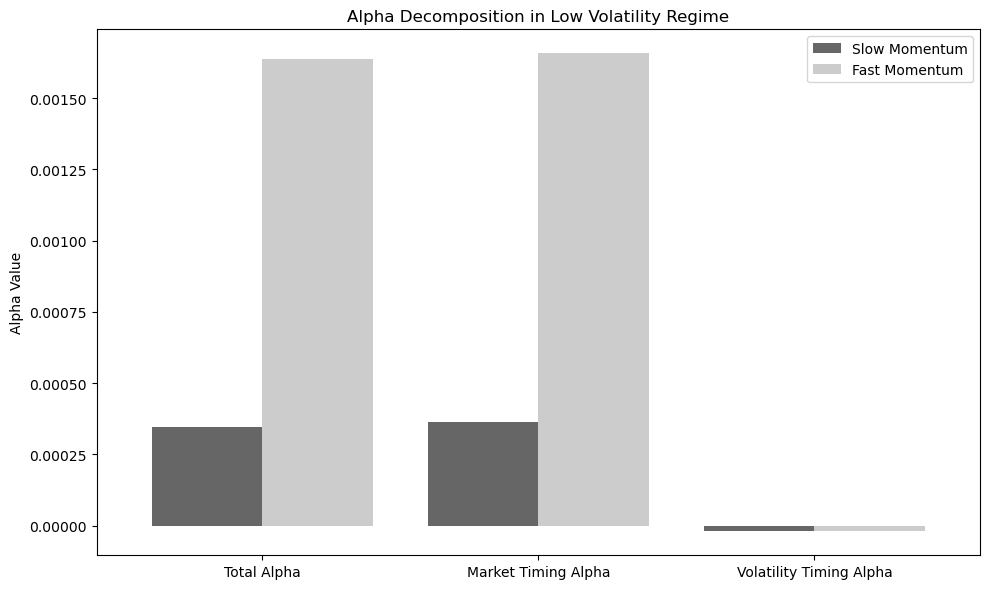

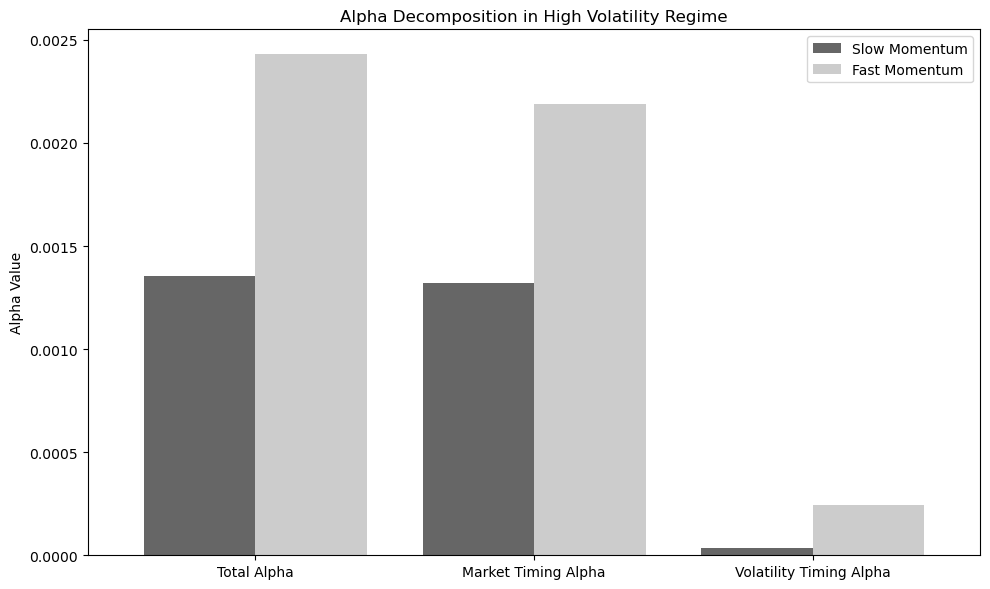

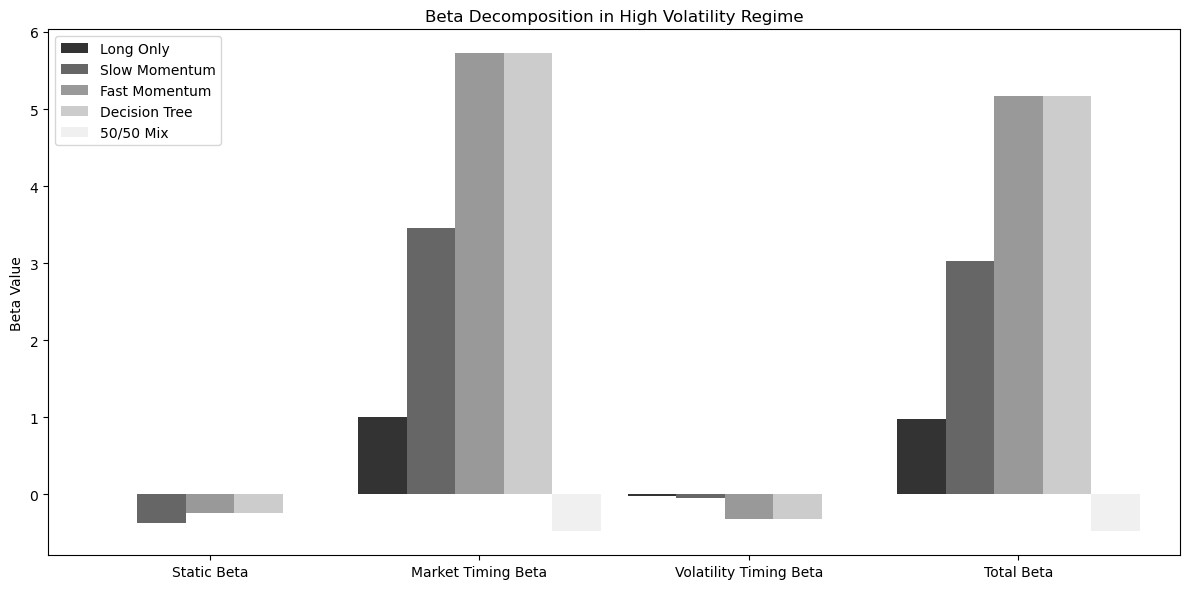

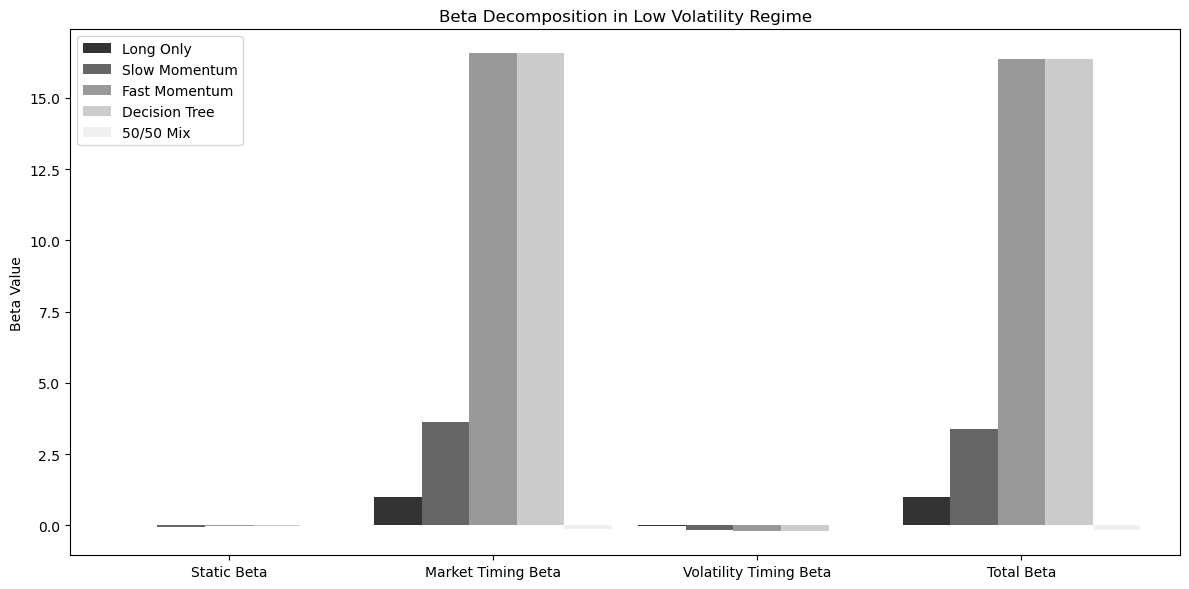

In [426]:
# 定义绘图函数
def plot_alpha_decomposition(alpha_data, title):
    labels = ['Total Alpha', 'Market Timing Alpha', 'Volatility Timing Alpha']
    slow_alpha = alpha_data[0]
    fast_alpha = alpha_data[1]
    
    x = np.arange(len(labels))  # 标签位置
    width = 0.4  # 柱状图宽度（增加宽度以减少留白）

    fig, ax = plt.subplots(figsize=(10, 6))
    # 使用不同灰度颜色
    rects1 = ax.bar(x - width/2, slow_alpha, width, label='Slow Momentum', color='#666666')  # 深灰色
    rects2 = ax.bar(x + width/2, fast_alpha, width, label='Fast Momentum', color='#CCCCCC')  # 浅灰色

    # 添加标签、标题和自定义x轴刻度标签等
    ax.set_ylabel('Alpha Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # 减少横坐标之间的留白
    ax.set_xlim(-0.6, len(labels) - 0.4)  # 调整横坐标范围
    fig.tight_layout()
    plt.show()

def plot_beta_decomposition(beta_data, title):
    labels = ['Static Beta', 'Market Timing Beta', 'Volatility Timing Beta', 'Total Beta']
    strategies = ['Long Only', 'Slow Momentum', 'Fast Momentum', 'Decision Tree', '50/50 Mix']
    
    x = np.arange(len(labels))  # 标签位置
    width = 0.18  # 柱状图宽度

    fig, ax = plt.subplots(figsize=(12, 6))
    # 使用不同灰度颜色
    grayscale_colors = ['#333333', '#666666', '#999999', '#CCCCCC', '#F0F0F0']  # 从深到浅的灰度
    for i, strategy in enumerate(strategies):
        rects = ax.bar(x + i*width - width*2, beta_data[i], width, label=strategy, color=grayscale_colors[i])

    # 添加标签、标题和自定义x轴刻度标签等
    ax.set_ylabel('Beta Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # 减少横坐标之间的留白
    ax.set_xlim(-0.6, len(labels) - 0.4)  # 调整横坐标范围
    fig.tight_layout()
    plt.show()

# 绘制低波动率下的 Alpha 分解
plot_alpha_decomposition([slow_alpha_low, fast_alpha_low], 'Alpha Decomposition in Low Volatility Regime')

# 绘制高波动率下的 Alpha 分解
plot_alpha_decomposition([slow_alpha_high, fast_alpha_high], 'Alpha Decomposition in High Volatility Regime')

# 绘制高波动率下的 Beta 分解
beta_data_high = [
    long_only_beta_high,
    slow_beta_high,
    fast_beta_high,
    decision_tree_beta_high,
    mix_beta_high
]
plot_beta_decomposition(beta_data_high, 'Beta Decomposition in High Volatility Regime')

# 绘制低波动率下的 Beta 分解
beta_data_low = [
    long_only_beta_low,
    slow_beta_low,
    fast_beta_low,
    decision_tree_beta_low,
    mix_beta_low
]
plot_beta_decomposition(beta_data_low, 'Beta Decomposition in Low Volatility Regime')